In [207]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy
from tensorflow.keras import regularizers
import numpy as np
import matplotlib.pyplot as plt
import os
import random

import cv2
import imghdr

## Input Data

In [208]:
data_dir = 'extradata'
image_exts = ['jpeg', 'jpg', 'bmp', 'png']

In [209]:
image_classes = [x for x in os.listdir(data_dir) if x[0] != '.'] # subdirectory of classes, rm hidden files '.[...]'

# Remove images with different extensions
for image_class in image_classes:
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try:
            img = cv2.imread(image_path)
            img_ext = imghdr.what(image_path)
            if img_ext not in image_exts or image == '.DS_STORE':
                print(f"Image not in ext list {image_path}")
                os.remove(image_path)
        except:
            print(f"Some other issue with image {image_path}")

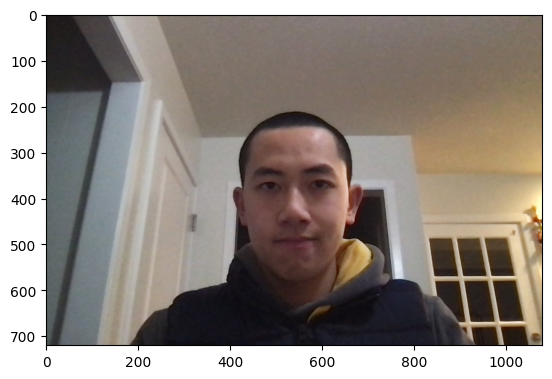

In [210]:
# Display image
img = cv2.imread(os.path.join(data_dir, 'face', '1.jpeg'))
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

## Load Data

In [38]:
tf.data.Dataset??

In [430]:
tf.keras.utils.image_dataset_from_directory??

In [160]:
# tf.keras pipeline processes data, stores in a generator
### resizes images to (256, 256)
### labels data based on directory classes
### batches images to set of 32 and shuffles it
data = tf.keras.utils.image_dataset_from_directory(data_dir, seed=1)

Found 15 files belonging to 2 classes.


In [161]:
data_iterator = data.as_numpy_iterator() # this is a generator

In [162]:
batch = data_iterator.next()

In [163]:
print(batch[0].shape, batch[1].shape) # batch of resized numpy arrays and its y labels
print(batch[1])

(15, 256, 256, 3) (15,)
[1 0 0 0 0 1 1 1 1 0 0 1 0 0 1]


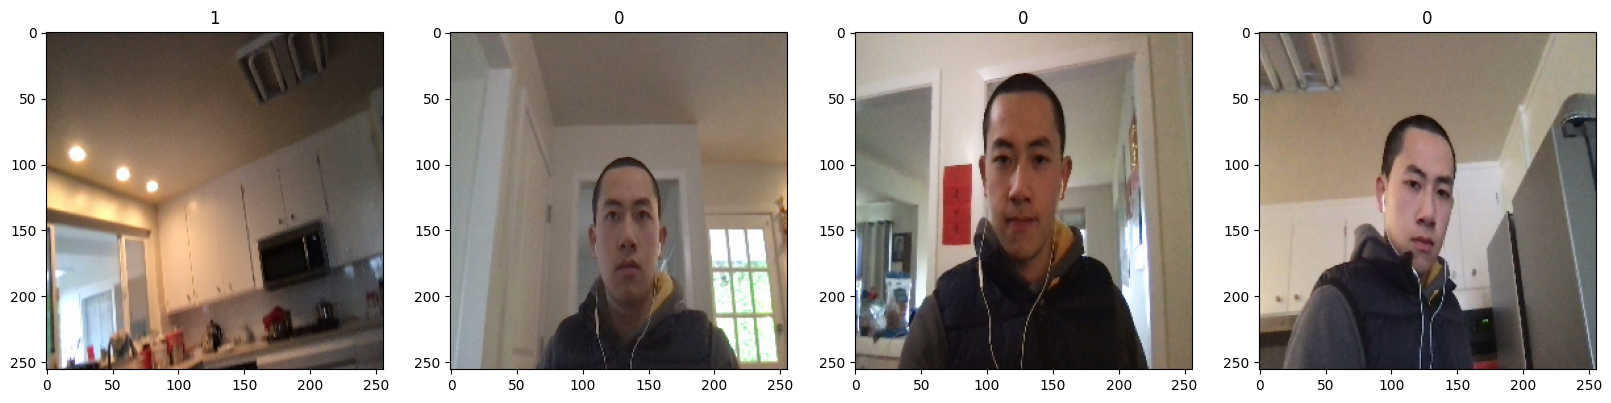

In [164]:
# Class 0 : Faces   Class 1 : Nonfaces
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

## Preprocess Data

In [165]:
# Scale data by dividing by 255
data = data.map(lambda x, y: (x / 255, y))

In [166]:
scaled_iterator = data.as_numpy_iterator() # new scaled generator

In [167]:
batch = scaled_iterator.next()

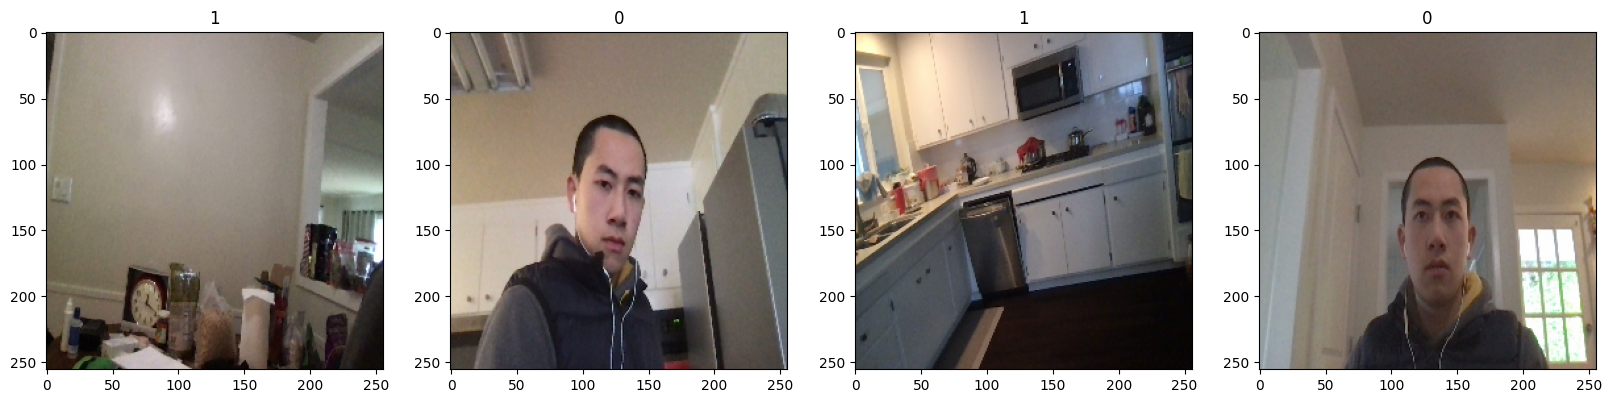

In [168]:
# Class 0 : Faces   Class 1 : Nonfaces
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img)
    ax[idx].title.set_text(batch[1][idx])

In [169]:
len(data) # of batches

1

In [170]:
# Manually split batches
train_size = 0
val_size = 0
test_size = 1

In [171]:
train = data.take(train_size)
val   = data.skip(train_size).take(val_size)
test  = data.skip(train_size + val_size).take(test_size)

In [172]:
type(test)

tensorflow.python.data.ops.dataset_ops.TakeDataset

In [173]:
len(train)

0

## Build and Train Model

In [59]:
model = Sequential([
    Conv2D(16, (3, 3), 1, activation='relu', input_shape=(256, 256, 3)),
    MaxPooling2D(),
    
    Conv2D(32, (3, 3), 1, activation='relu'),
    MaxPooling2D(),
    
    Conv2D(16, (3, 3), 1, activation='relu'),
    MaxPooling2D(),
    
    Flatten(),
    
    Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    Dense(1, activation='sigmoid')
])

In [100]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 127, 127, 16)     0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 62, 62, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 30, 30, 16)      

In [101]:
model.compile(optimizer='adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [102]:
# Set up logs to log model metrics to file 'logs'
log_dir = 'logs'

In [103]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)

In [104]:
hist = model.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/20
29/29 [==============================] - 23s 720ms/step - loss: 4.7110 - accuracy: 0.8998 - val_loss: 1.6230 - val_accuracy: 0.9312
Epoch 2/20
29/29 [==============================] - 25s 864ms/step - loss: 0.9254 - accuracy: 0.9386 - val_loss: 0.4572 - val_accuracy: 0.9438
Epoch 3/20
29/29 [==============================] - 28s 959ms/step - loss: 0.3698 - accuracy: 0.9472 - val_loss: 0.2446 - val_accuracy: 0.9406
Epoch 4/20
29/29 [==============================] - 32s 1s/step - loss: 0.2378 - accuracy: 0.9472 - val_loss: 0.1849 - val_accuracy: 0.9531
Epoch 5/20
29/29 [==============================] - 42s 1s/step - loss: 0.1979 - accuracy: 0.9526 - val_loss: 0.1219 - val_accuracy: 0.9781
Epoch 6/20
29/29 [==============================] - 31s 1s/step - loss: 0.2013 - accuracy: 0.9580 - val_loss: 0.1552 - val_accuracy: 0.9688
Epoch 7/20
29/29 [==============================] - 34s 1s/step - loss: 0.1887 - accuracy: 0.9526 - val_loss: 0.1559 - val_accuracy: 0.9625
Epoch 8/20


In [105]:
hist.history

{'loss': [4.711001873016357,
  0.9254242181777954,
  0.3698151409626007,
  0.2377943992614746,
  0.19789542257785797,
  0.2012767195701599,
  0.18866416811943054,
  0.18924187123775482,
  0.16506929695606232,
  0.3148857653141022,
  0.23041273653507233,
  0.17779891192913055,
  0.16588784754276276,
  0.1596291959285736,
  0.20526786148548126,
  0.16628897190093994,
  0.16013117134571075,
  0.14856268465518951,
  0.22435680031776428,
  0.171213760972023],
 'accuracy': [0.899784505367279,
  0.9385775923728943,
  0.9471982717514038,
  0.9471982717514038,
  0.9525862336158752,
  0.9579741358757019,
  0.9525862336158752,
  0.9590517282485962,
  0.9493534564971924,
  0.9224137663841248,
  0.9396551847457886,
  0.951508641242981,
  0.9579741358757019,
  0.9655172228813171,
  0.9558189511299133,
  0.9633620977401733,
  0.9698275923728943,
  0.9644396305084229,
  0.9418103694915771,
  0.9590517282485962],
 'val_loss': [1.6229768991470337,
  0.45721855759620667,
  0.2446226328611374,
  0.1849349

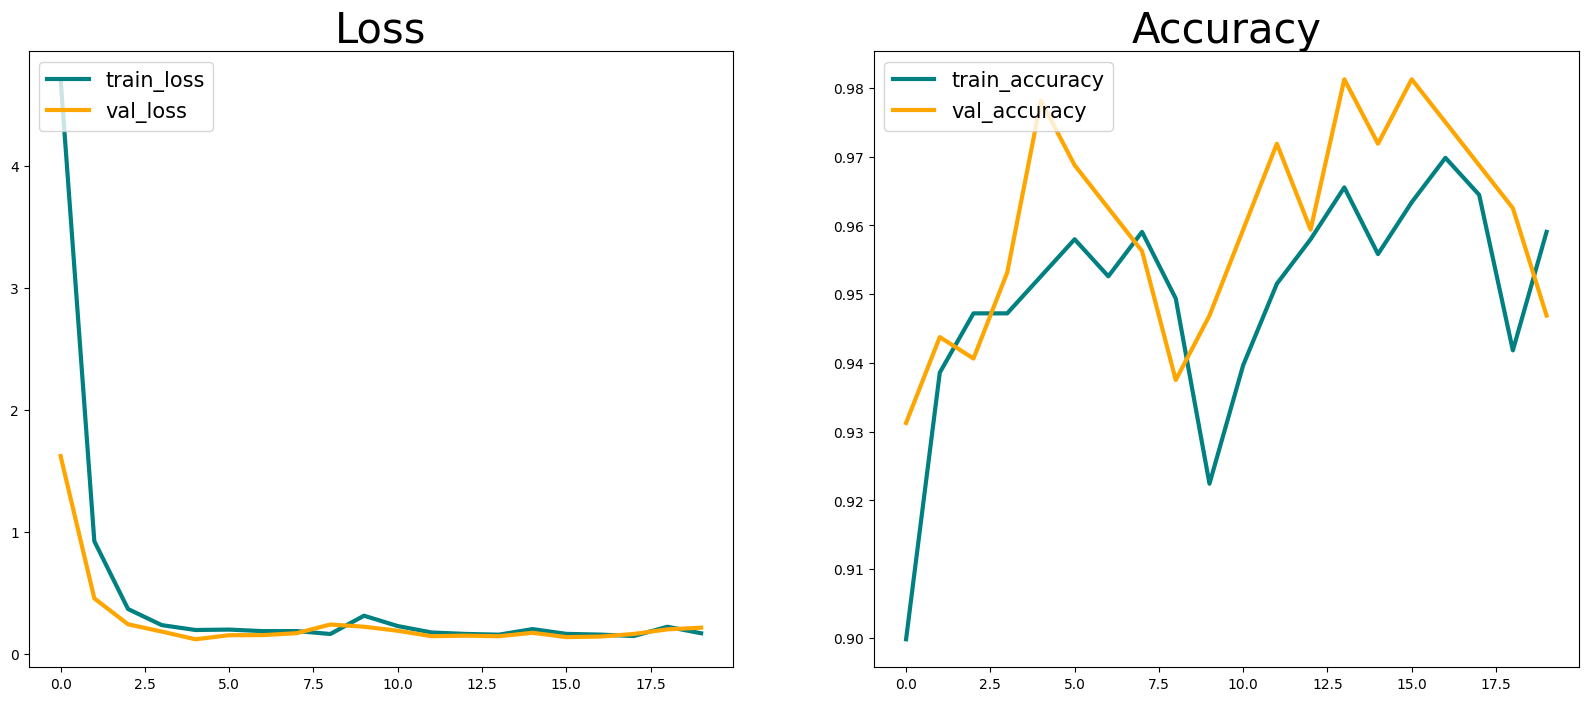

In [106]:
# Plot loss and accuracy from the stored hist logs
fig, ax = plt.subplots(ncols=2, figsize=(20,8))
ax[0].plot(hist.history['loss'], color='teal', linewidth=3, label='train_loss')
ax[0].plot(hist.history['val_loss'], color='orange', linewidth=3, label='val_loss')
ax[0].set_title('Loss', fontsize=30)
ax[0].legend(loc='upper left', fontsize=15)
ax[1].plot(hist.history['accuracy'], color='teal', linewidth=3, label='train_accuracy')
ax[1].plot(hist.history['val_accuracy'], color='orange', linewidth=3, label='val_accuracy')
ax[1].set_title('Accuracy', fontsize=30)
ax[1].legend(loc='upper left', fontsize=15)

## Evaluate and Test Model

In [174]:
# Get precision, recall, accuracy, F1 metrics
pre = Precision()
rec = Recall()
acc = BinaryAccuracy()

In [175]:
# Get metrics for each test batch
for batch in test.as_numpy_iterator():
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    rec.update_state(y, yhat)
    acc.update_state(y, yhat)

1/1 [==============================] - 0s 93ms/step


In [176]:
pre = pre.result().numpy(); rec = rec.result().numpy(); acc = acc.result().numpy()
f1 = 2 * pre * rec / (pre + rec)
print(f"Precision: {pre}  Recall: {rec}  Accuracy {acc}")
print(f"F1 Score: {f1}")

Precision: 1.0  Recall: 0.2857142984867096  Accuracy 0.6666666865348816
F1 Score: 0.4444444701995382


In [177]:
test_iterator = test.as_numpy_iterator()

In [178]:
batch = test_iterator.next()

In [179]:
batch[0][0].shape

(256, 256, 3)

1/1 [==============================] - 0s 26ms/step


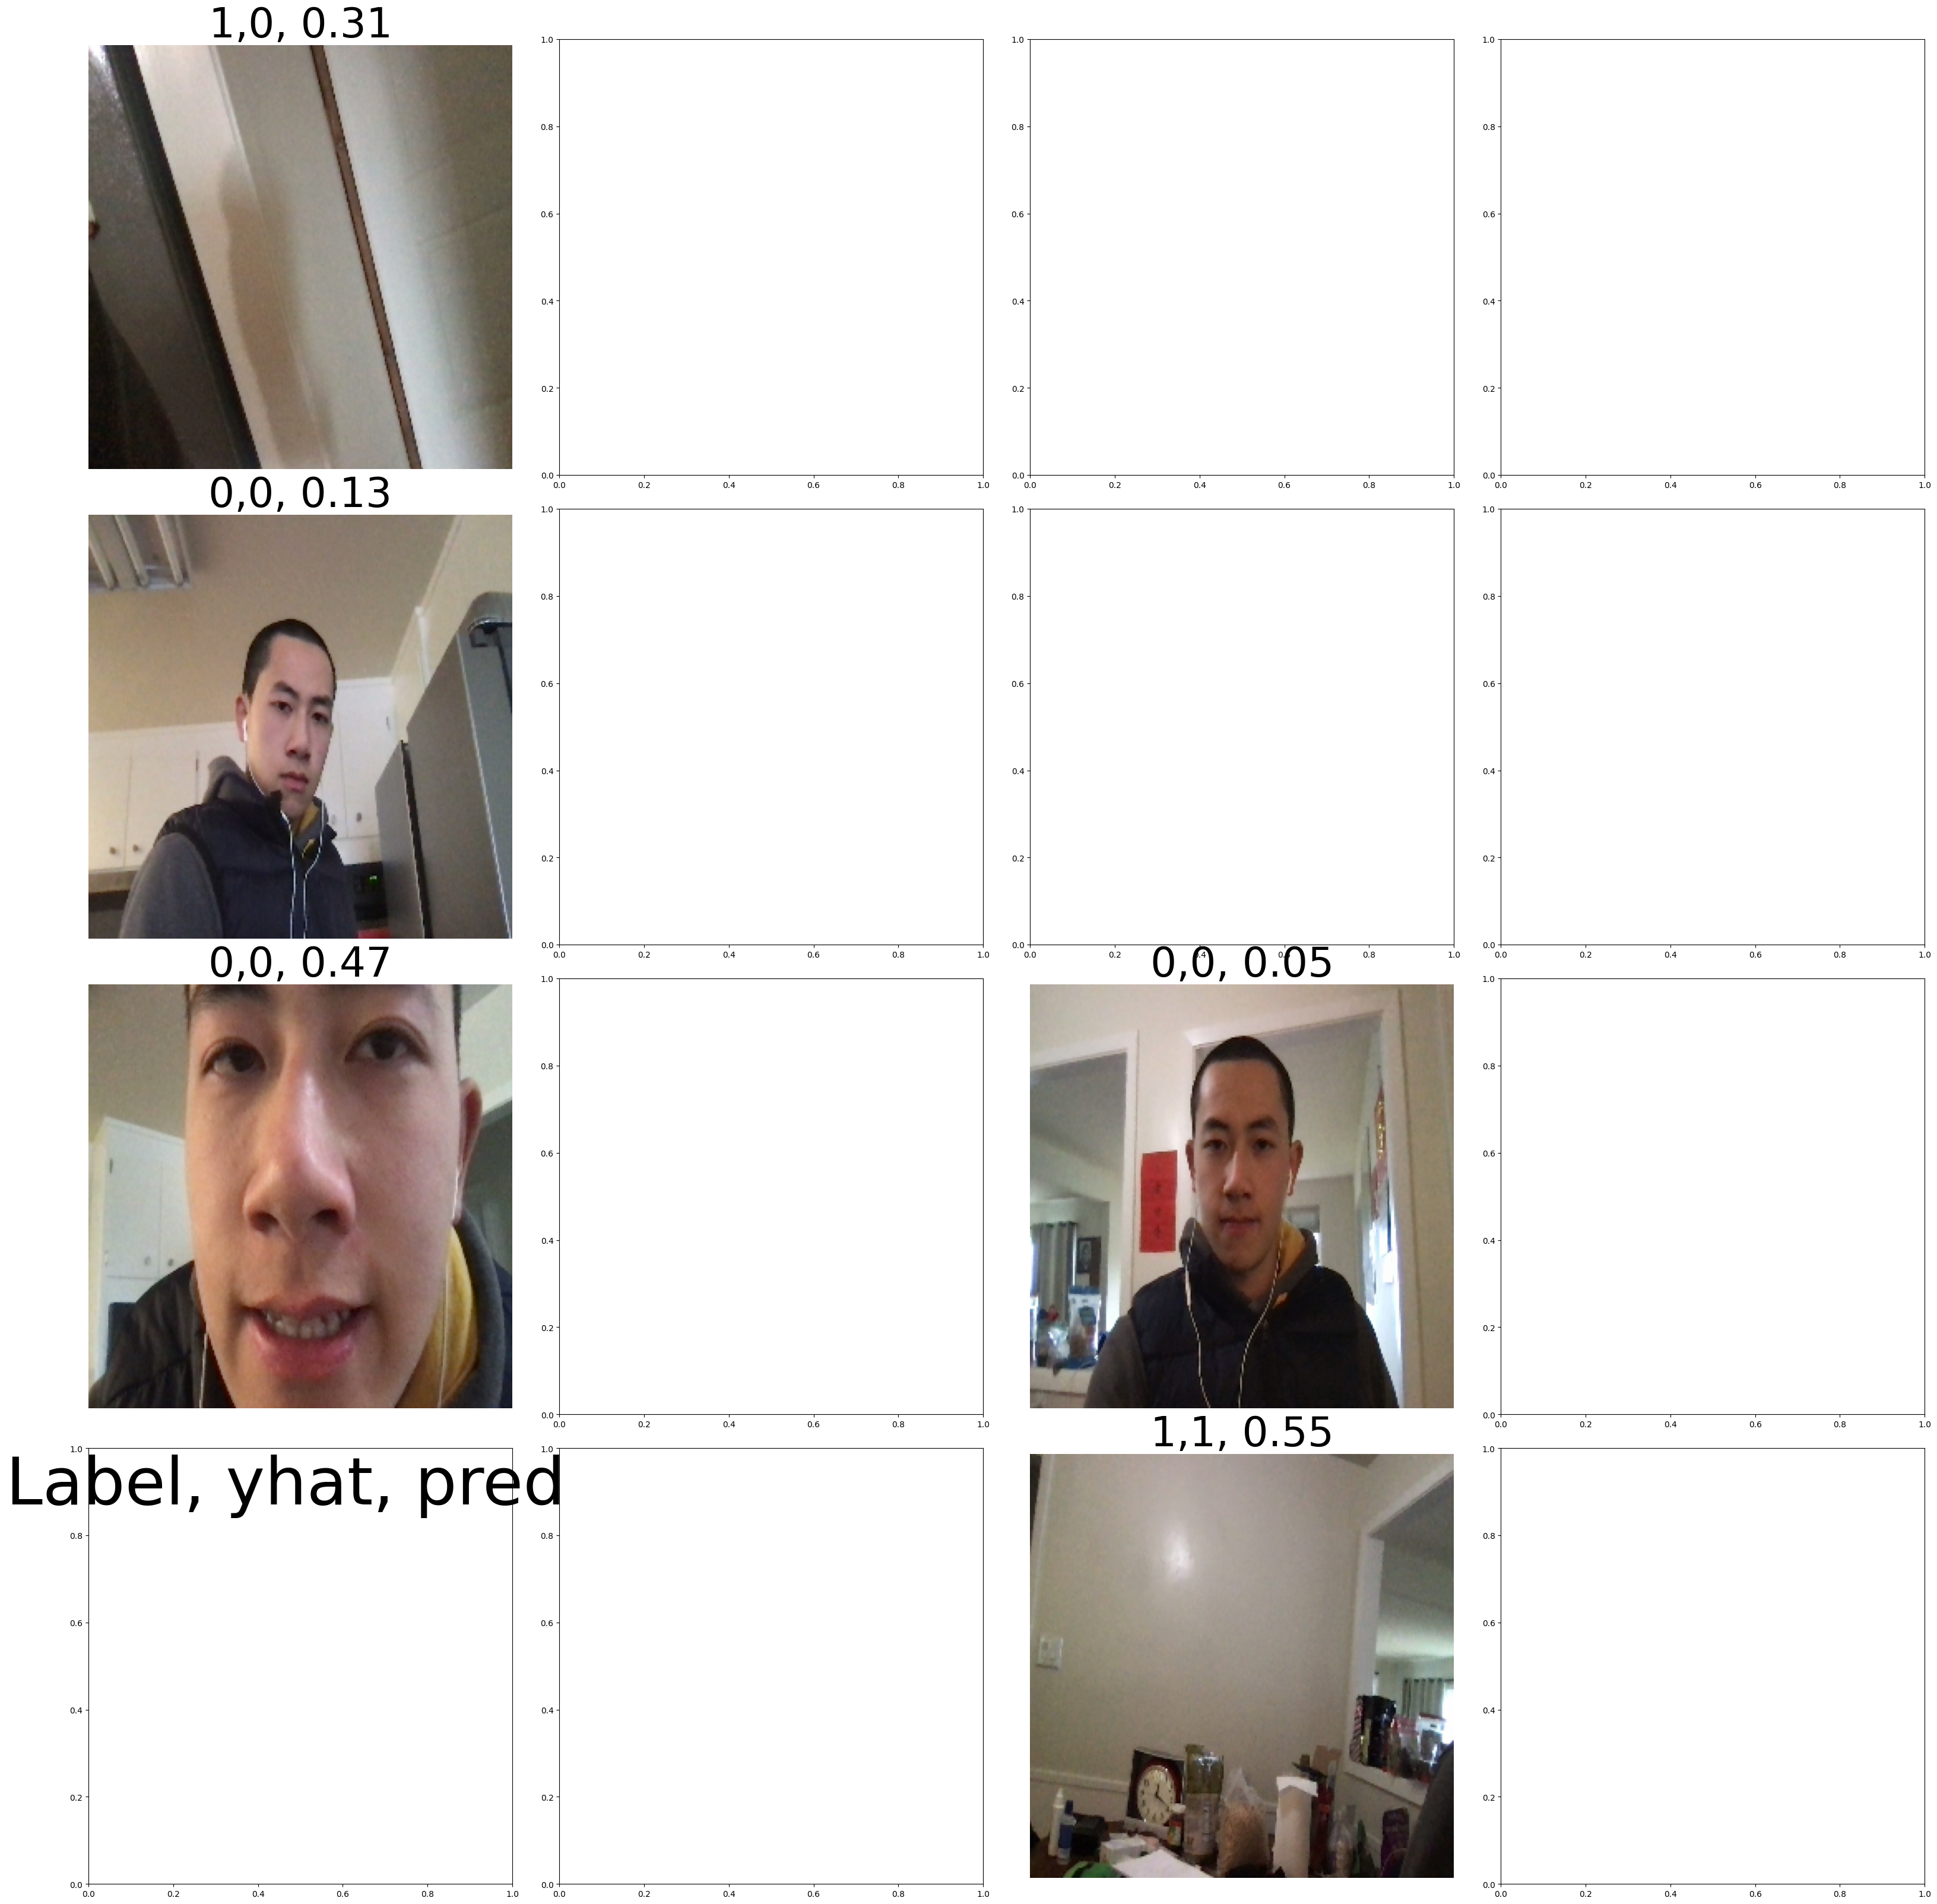

In [187]:
# Compare y label and prediction, display images with labels
fig, axes = plt.subplots(4, 4, figsize=(8, 8))
fig.tight_layout(pad=2,rect=[0, 0.01, 4, 4]) #[left, bottom, right, top]
for i, ax in enumerate(axes.flat):
    random_index = np.random.randint(31)
    try:
        X_random = batch[0][random_index] # "{:.2f}".format(round(a, 2))
    except:
        continue
    ax.imshow(X_random)
    pred = model.predict(np.array([X_random]))
    yhat = int(pred >= 0.5)
    ax.set_title(f"{batch[1][random_index]},{yhat}, {pred[0,0]:.2f}", fontsize=50)
    ax.set_axis_off()
fig.suptitle('Label, yhat, pred', fontsize=80)
plt.show()

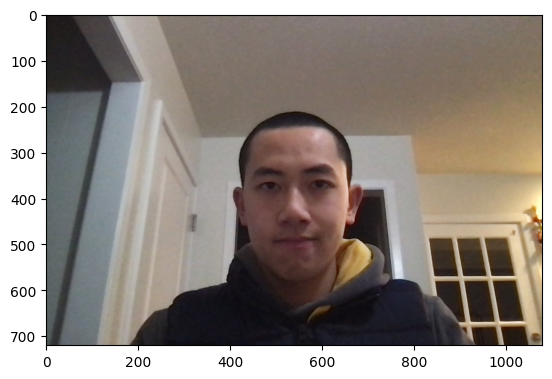

In [212]:
# Test single image, pass to model
img = cv2.imread('extradata/face/1.jpeg')
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

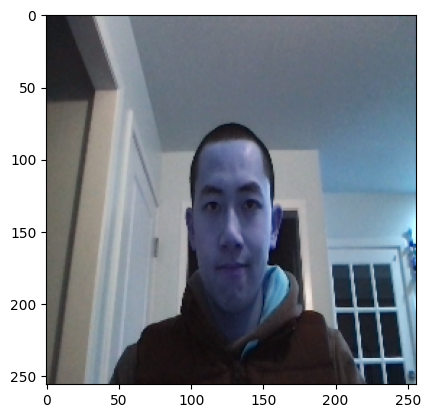

In [213]:
resize = tf.image.resize(img, (256, 256)) # resize image
plt.imshow(resize.numpy().astype(int))

In [214]:
X_img = resize / 255 # Scale image for new inputs before feeding into model
# Model expects shape=(batch, 256, 256, 3)
X_img = np.expand_dims(X_img, 0) # Add 1 dimension for batch # -> shape=(1, 256, 256, 3)

In [215]:
yhat = model.predict(X_img)

1/1 [==============================] - 0s 43ms/step


In [216]:
print(yhat[0,0])
if yhat > 0.5:
    print("Predicted class: Not Face")
else:
    print("Predicted class: Face")

0.055401724
Predicted class: Face


In [199]:
model.save('models/facedetectmodel3.h5')

In [211]:
loaded_model = tf.keras.models.load_model('models/facedetectmodel3.h5') # load model

In [63]:
# Copy weights of old model to new model
model.set_weights(loaded_model.get_weights())

In [206]:
for idx, image in enumerate(os.listdir('extradata/nonface')):
    img = cv2.imread(os.path.join('extradata', image))
    print(image)
    try:
        resize = tf.image.resize(img, (256, 256))
    except:
        continue
    X_img = resize / 255
    X_img = np.expand_dims(X_img, 0)
    yhat = model.predict(X_img)
    
    print(yhat)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    if idx == 3:
        break

f.jpeg
1.jpeg
Photo on 1-11-23 at 12.19 PM.jpg
Photo on 1-11-23 at 12.19 PM #5.jpg
Photo on 1-11-23 at 12.19 PM #4.jpg
Photo on 1-11-23 at 12.19 PM #6.jpg
Photo on 1-11-23 at 12.19 PM #7.jpg
Photo on 1-11-23 at 12.19 PM #3.jpg
Photo on 1-11-23 at 12.19 PM #2.jpg


[ WARN:0@8535.636] global loadsave.cpp:244 findDecoder imread_('extradata/f.jpeg'): can't open/read file: check file path/integrity
[ WARN:0@8535.637] global loadsave.cpp:244 findDecoder imread_('extradata/1.jpeg'): can't open/read file: check file path/integrity
[ WARN:0@8535.637] global loadsave.cpp:244 findDecoder imread_('extradata/Photo on 1-11-23 at 12.19 PM.jpg'): can't open/read file: check file path/integrity
[ WARN:0@8535.638] global loadsave.cpp:244 findDecoder imread_('extradata/Photo on 1-11-23 at 12.19 PM #5.jpg'): can't open/read file: check file path/integrity
[ WARN:0@8535.638] global loadsave.cpp:244 findDecoder imread_('extradata/Photo on 1-11-23 at 12.19 PM #4.jpg'): can't open/read file: check file path/integrity
[ WARN:0@8535.638] global loadsave.cpp:244 findDecoder imread_('extradata/Photo on 1-11-23 at 12.19 PM #6.jpg'): can't open/read file: check file path/integrity
[ WARN:0@8535.638] global loadsave.cpp:244 findDecoder imread_('extradata/Photo on 1-11-23 at 1